In [104]:
#for importing, formatting and data manipulation
import pandas as pd
import numpy as np
import glob
import datetime
#from time import time
#from datetime import datetime
#from datetime import timedelta
import tempfile
from qiime2 import Artifact
import zipfile
import yaml
import json

#for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib_venn import venn3, venn3_circles
import seaborn as sns
#sns.set(style="whitegrid")
import plotly.express as px
%matplotlib inline
from IPython.display import display
from upsetplot import plot
#import pyupset as pyu
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()

#for statistical analyses
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from skbio.diversity import alpha_diversity
from skbio.stats.distance import permanova
from skbio import DistanceMatrix
from scipy.spatial.distance import cdist
from skbio.stats.composition import clr
from skbio.stats.composition import alr
from skbio.stats.composition import ilr
from skbio.diversity.alpha import chao1

## Import and format metadata from lab, and BBMP

### Import lab metadata

In [2]:
def load_df():
    
    filenames = glob.glob('/Users/Diana/Documents/escuela/phd/ch2/bb_data/20**/METADATA.txt')
    #load all metadata and concatenate them into one dataframe
    md = []
    for filename in filenames:
        df = pd.read_csv(filename, sep='\t')
        md.append(df)
        print (filename)
    
    md = pd.concat(md)
    
    #drop empty columns and rows
    md.dropna(how='all', axis=1, inplace=True) #empty cols
    md.dropna(how='all', inplace=True) #empty rows
    
    return md

In [3]:
md = load_df()

/Users/Diana/Documents/escuela/phd/ch2/bb_data/2014/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2022/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2015/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2017/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2019/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2021/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2020/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2018/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2016/METADATA.txt


#### Renumber dates

In [4]:
#create a dictionary for months
month_dic = {
    "Jan": 1,
    "Feb": 2,
    "Mar": 3,
    "Apr": 4,
    "May": 5,
    "Jun": 6,
    "Jul": 7,
    "Aug": 8,
    "Sep": 9,
    "Oct": 10,
    "Nov": 11,
    "Dec": 12
}
month_season = {
    "Jan": "Winter",
    "Feb": "Winter",
    "Mar": "Spring",
    "Apr": "Spring",
    "May": "Spring",
    "Jun": "Summer",
    "Jul": "Summer",
    "Aug": "Summer",
    "Sep": "Autumn",
    "Oct": "Autumn",
    "Nov": "Autumn",
    "Dec": "Winter"
}
depth_num = {
    "A": 1,
    "B": 5,
    "C": 10,
    "D": 60,
    "E": 30
}

In [5]:
#add month to a new column
md['month_name'] = md['date'].str.split('-').str[1]

#add month number
md['month']= md['month_name'].map(month_dic)

#add day number
md['day'] = md['date'].str.split('-').str[0]
md[["year", "month", "day"]] = md[["year", "month", "day"]].apply(pd.to_numeric)

#remove symbol for better handling of data
#md.rename(columns={"Week#": "Weekn"}, inplace=True)
#md.rename(columns={"Depth": "depth"}, inplace=True) #to match dfo

#change to int to remove decimals from date columns
md.year = md.year.apply(int)
md.depth = md.depth.apply(int)
md.weekn = md.weekn.apply(int)

#change to str to aggregate them into time_string to match dfos formatting of the date
md.year = md.year.apply(str)
md.month = md.month.apply(str)
md.day = md.day.apply(str)
#add leading zero to match date format in dfo metadata
md['month'] = md['month'].str.zfill(2)
md['day'] = md['day'].str.zfill(2)

#add leading zero to match date format in dfo metadata
md['month'] = md['month'].str.zfill(2)
md['day'] = md['day'].str.zfill(2)

md['time_string'] = md[['year', 'month', 'day']].agg('-'.join, axis=1)

### Import and manage BBMP data

#### Metadata __md__ is formatted. It contains 38 columns.
__md__ is the lab's metadata for sampling, extraction and sequencing. \
__dfo_md__ is BBMP remote sensing data (salinity, pH, temperature, density..) \
__bio_niskin__ is nutrient data \
Format __bio_niskin__ data to merge with __md__. __bio_niskin__ is 32 columns, including year, month, day, and depth. __dfo_md__ also has 32 columns, including year_time, month_time, day_time. To merge these data with __md__, we will change the time stamps columns to the same name, and generate a time_string column.

In [6]:
dfo_md = pd.read_csv("/Users/Diana/Documents/escuela/phd/ch2/bb_data/bbmp_aggregated_profiles.csv")
bio_niskin = pd.read_csv("/Users/Diana/Documents/escuela/phd/ch2/bb_data/BBMP_Data_2022.csv")#
#dfo_metadata_y14 = pd.read_csv("/Users/Diana/Documents/escuela/phd/bb_data/2019/data_export/trim-analysis/dfo_metadata_y14.tsv", sep='\t')

#change to str to aggregate them into time_string
bio_niskin.year = bio_niskin.year.apply(str)
bio_niskin.month = bio_niskin.month.apply(str)
bio_niskin.day = bio_niskin.day.apply(str)
#add leading zero to match date format in dfo metadata
bio_niskin['month'] = bio_niskin['month'].str.zfill(2)
bio_niskin['day'] = bio_niskin['day'].str.zfill(2)

bio_niskin['time_string'] = bio_niskin[['year', 'month', 'day']].agg('-'.join, axis=1)

#make a new column for time_string without the time
dfo_md['time_string_time'] = dfo_md['time_string']
dfo_md['time_string'] = dfo_md['time_string'].str.split(' ').str[0]

#renaming columns to ensure correct merging
dfo_md.rename(columns={"depth":"bbmpdepth","pressure": "depth", "year_time": "year", "month_time": "month", "day_time": "day"}, inplace=True)

#change to int to remove decimals from date columns
cols = ['year', 'depth', 'month', 'day']
md[cols] = md[cols].apply(pd.to_numeric, errors='ignore', axis=1)
dfo_md[cols] = dfo_md[cols].apply(pd.to_numeric, errors='ignore', axis=1)
bio_niskin[cols] = bio_niskin[cols].apply(pd.to_numeric, errors='ignore', axis=1)

#make a season column
md['season'] = ''

for month, season in month_season.items():
    md.loc[md['month_name'] == month, 'season'] = season

#merging party
merged = pd.merge(md, dfo_md, on=["year", "month", "depth", "day"], how="left")
allyears = pd.merge(md, dfo_md, on=["year", "month", "depth", "day"], how="outer")

#add nutrient data
preall_md= pd.merge(allyears, bio_niskin, on=["day", "month", "year", 'depth'], how="outer")
all_md = pd.merge(merged, bio_niskin, on=["day", "month", "year", 'depth'], how="left")

#split dfs by depth
shallow_depths = [1, 5, 10]
shallow = all_md[all_md["depth"] < 30]
#shallow = shallow.groupby(['year', 'month', "day"]).mean().reset_index()
deep = all_md[all_md.depth == 60]

#split dfs by season
year_season = preall_md.groupby(by = ['year','season']).mean().reset_index()

Winter = year_season.loc[year_season['season'] == 'Winter',:]
Spring = year_season.loc[year_season['season'] == 'Spring',:]
Summer = year_season.loc[year_season['season'] == 'Summer',:]
Autumn = year_season.loc[year_season['season'] == 'Autumn',:]

#save output as csv
all_md.to_csv('allmetadata.csv')

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_64907/2823838939.py:35: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  merged = pd.merge(md, dfo_md, on=["year", "month", "depth", "day"], how="left")
/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_64907/2823838939.py:36: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  allyears = pd.merge(md, dfo_md, on=["year", "month", "depth", "day"], how="outer")
/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_64907/2823838939.py:40: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  all_md = pd.merge(merged, bio_niskin, on=["day", "month", "year", 'depth'], how="left")
/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_64907/2823838939.py:49: FutureWarning: The default value of numeric_only in

## Find missing data

In [7]:
emptynit = all_md[all_md['Nitrate'].isna()]

## Plotting party

In [ ]:
#plotly seasonal averages figure
fig2 = go.Figure()
for template in ["plotly_white"]:
    fig2.add_trace(go.Scatter(x=Winter['year'], y=Winter['temperature'],
                    mode='lines',
                    name='Winter',
                    marker_color='#838B8B'))
    fig2.add_trace(go.Scatter(x=Spring['year'], y=Spring['temperature'],
                    mode='lines',
                    name='Spring',
                    marker_color='#FFB5C5'))
    fig2.add_trace(go.Scatter(x=Summer['year'], y=Summer['temperature'],
                    mode='lines',
                    name='Summer',
                    marker_color='#87CEFF'))
    fig2.add_trace(go.Scatter(x=Autumn['year'], y=Autumn['temperature'],
                    mode='lines',
                    name='Autumn',
                    marker_color='#FF8000'))
    fig2.update_layout(
    height=800,
    xaxis_title="Years",
    yaxis_title='Temperature in degree',
    title_text='Average Temperature seasonwise over the years',
    template=template)

fig2.show()

In [ ]:
#seaborn season averages plot
sns.lineplot(year_season['year'],year_season['temperature'], hue =year_season["season"])

In [ ]:
plt.style.use('ggplot')

### Detect and plot anomalies in variables

In [ ]:
def detect_anomalies(metadata, depth, yr=all, month=all):
    md_col = depth[['weekn', metadata, "year", "month"]].copy()
    md_col = md_col[md_col[metadata].notna()]
    if yr != all:
        #mdcol_yr = md_col[md_col.Year == yr]
        mdcol_yr = md_col[md_col['year'].isin(yr)]
    else: 
        mdcol_yr = md_col
        
    if month != all:
        #mdcol_yr = mdcol_yr[mdcol_yr.Month == month]
        mdcol_yr = mdcol_yr[mdcol_yr['month'].isin(month)]
    
    mdcol_yr = mdcol_yr.drop(columns=['year', "month"])
    mdcol_yr = mdcol_yr.set_index(['weekn'])
    
    #modelling time
    outliers_fraction = float(.01)
    scaler = StandardScaler()
    np_scaled = scaler.fit_transform(mdcol_yr.values.reshape(-1, 1))
    data = pd.DataFrame(np_scaled)
    # train isolation forest
    model =  IsolationForest(contamination=outliers_fraction)
    model.fit(data)
    
    #predict data
    mdcol_yr['anomaly'] = model.predict(data)
    
    
    # visualization
    fig, ax = plt.subplots(figsize=(10,6))
    a = mdcol_yr.loc[mdcol_yr['anomaly'] == -1, [metadata]] #anomaly
    ax.plot(mdcol_yr.index, mdcol_yr[metadata], color='black', label = 'Normal')
    ax.scatter(a.index,a[metadata], color='red', label = 'Anomaly')
    plt.axvline(36, ls='--')
    plt.legend()
    plt.show();
    #add axes names

In [ ]:
detect_anomalies('Phosphate', shallow, yr={2022}, month={1,2,3})

## Add prokaryotic community

#### Upload functions

In [77]:
# Special thanks to Alex Manuele https://github.com/alexmanuele
def consolidate_tables(MG):
    if MG == '16S':
        comm = '02-PROKs'
    else :
        comm = '02-EUKs'
        
    table_list = glob.glob('{0}/table.qza'.format('/Users/Diana/Documents/escuela/phd/size_fractions/BB22_size-fraction-comparison-analysed/to_transfer/'+comm))
    print("Found all "+MG+" tables.")

        
    dataframes = []  
    for table_path in table_list:
        with tempfile.TemporaryDirectory() as tempdir:
            #load table, dump contents to tempdir
            table = Artifact.load(table_path)
            #Make sure the tables are all FeatureFrequency type
            assert str(table.type) == 'FeatureTable[Frequency]', "{0}: Expected FeatureTable[Frequency], got {1}".format(table_path, table.type)
            Artifact.extract(table_path, tempdir)
            #get the provenance form the tempdir and format it for DF
            prov = '{0}/{1}/provenance/'.format(tempdir, table.uuid)
            action = yaml.load(open("{0}action/action.yaml".format(prov), 'r'), Loader=yaml.BaseLoader)
            paramlist = action['action']['parameters']
            paramlist.append({'table_uuid': "{}".format(table.uuid)})
            paramdict = {}
            for record in paramlist:
                paramdict.update(record)

            # Get the data into a dataframe
              #Biom data
            df = table.view(pd.DataFrame).unstack().reset_index()
            df.columns = ['feature_id', 'sample_name', 'feature_frequency']
            df['table_uuid'] = ["{}".format(table.uuid)] * df.shape[0]
              #param data
            pdf = pd.DataFrame.from_records([paramdict])
              #merge params into main df
            df = df.merge(pdf, on='table_uuid')
            

            #I like having these columns as the last three. Makes it more readable
            cols = df.columns.tolist()
            reorder = ['sample_name', 'feature_id', 'feature_frequency']
            for val in reorder:
                cols.append(cols.pop(cols.index(val)))
            df = df[cols]
            df['table_path'] = [table_path] * df.shape[0]
            df['sample_name'] = df['sample_name'].str.replace('-', '.')
            dataframes.append(df)
            
            # Adding table_id, forward and reverse trim columns
            #df['table_id'] = str(table_path.split('/')[-3]) #add a table_id column
            #df['forward_trim'], df['reverse_trim'] = df['table_id'].str.split('R', 1).str
            #df['forward_trim'] = df['forward_trim'].map(lambda x: x.lstrip('F'))
            #df["forward_trim"] = pd.to_numeric(df["forward_trim"])
            #df["reverse_trim"] = pd.to_numeric(df["reverse_trim"])

    #Stick all the dataframes together
    #outputfile="merged_all_tables.tsv"
    df = pd.concat(dataframes)
    df['sample_name'] = df['sample_name'].str.replace(r'\.S([1-9]|[1-9][0-9]|[1-9][0-9][0-9]).L001\.','', regex=True)
    
    #df.to_csv(comm+'/merged_all_tables.tsv', sep='\t', index=False)
    print("Successfully saved all tables.")
    return df, comm

In [9]:
def merge_metadata(df):
    #df = pd.read_csv('02-PROKs/'+'/merged_all_tables.tsv', sep='\t')

    tables = df[['sample_name', 'feature_id', 'feature_frequency']].copy()
    tables.rename(columns={'sample_name':'sampleid'}, inplace=True)

    all_md['sampleid'] = all_md['sampleid'].str.replace('_', '.')
    merged = pd.merge(tables,all_md, on='sampleid', how='left') #all_md is the metadata file
    merged = merged[merged.feature_frequency != 0]
    
    merged['year'] = 2022
    merged["size_code"] = ''

    merged["size_code"] = merged["sampleid"].str.extract(r'[1-9][0-9]?[A-E]([L-S])')
    merged["size_code"] = merged["size_code"].fillna('W')
    merged["depth_code"] = merged["sampleid"].str.extract(r'[1-9][0-9]?([A-E])')
    merged['depth']= merged['depth_code'].map(depth_num)
    merged["weekn"] = merged["sampleid"].str.extract(r'\.([1-9][0-9]?)[A-E]')
    merged['weekn'] = pd.to_numeric(merged['weekn'])
    merged['depth'] = pd.to_numeric(merged['depth'])
    merged['date'] = merged.groupby('weekn', as_index=False)['date'].transform('first')
    
    merged['Total'] = merged['feature_frequency'].groupby(merged['sampleid']).transform('sum')
    merged['ratio'] = merged['feature_frequency']/merged['Total']
    merged['nASVs'] = merged['feature_id'].groupby(merged['sampleid']).transform('count')
    merged['weekdepth'] = merged["weekn"].astype(str) + merged["depth"].astype(str)
    merged['avg'] = merged['nASVs'].groupby(merged['weekdepth']).transform('mean')
    merged['diff'] = merged['nASVs'] - merged['avg']

    print('Set up metadata ...')
    
    #merged.to_csv(comm+'/merged_asvs_metadata.tsv', sep = '\t')
    print('Saved merged_asvs_metadata.tsv')
    
    return merged

In [10]:
def pick_metadata(merged, depth='all', size_fraction='both', year='all', R='all', F='all', txsubset = 'all'):
#make df of features/composition+run+comm

    depth = depth
    year = year
    size_fraction = size_fraction
    txsubset = txsubset
        
    files = glob.glob('{0}/*/class/*/data/taxonomy.tsv'.format('/Users/Diana/Documents/escuela/phd/size_fractions/BB22_size-fraction-comparison-analysed/to_transfer'))
    taxos = []
#    if not os.path.exists(path+composition):
#        os.mkdir(path+composition)
    for filename in files:
        tax = pd.read_csv(filename, sep='\t')
        taxos.append(tax)
        
    print('Appended all taxonomies to taxos')
    taxos = pd.concat(taxos)
    taxos = taxos.rename(columns={"Feature ID": "feature_id"}, errors="raise")
    taxos = taxos.drop_duplicates()

    separated = merged.merge(taxos, how='left', on='feature_id') #merged excludes features of frequency = 0
    separated = separated.drop_duplicates()
    
    if depth != 'all':
        separated = separated[separated["depth"] == depth]
    if size_fraction != 'both':
        separated = separated[separated["size_fraction"] == size_fraction]

    separated[['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']] = separated['Taxon'].str.split('; ', expand=True)
    cols = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
    for col in cols:
        separated[col] = separated[col].fillna('Unassigned')
    
    #separated['total'] = separated.groupby(['table_id','sample-id'])['feature_frequency'].transform('sum')
    #separated['ratio'] = separated['feature_frequency']/(separated['total'])
    #separated_taxonomies = separated.copy()
    
    #make a dictionary with keys for id-ing the taxon belonging to this sub-community
    #separated_dic = pd.Series(separated.Taxon.values,separated.feature_id.values).to_dict()
    print('Saved separated by metadata dataframe.')
    
    return separated

In [17]:
def taxbarplot(separated, level, depth, topn): #separated is the df, #level is a string of taxonomic level column name, depth is an integer
    sfd=separated[separated.depth==depth]
    toptaxa = sfd[['feature_id', 'feature_frequency', 'Taxon', 'size_code', 'depth','weekn', level]].copy()
    toptaxa = toptaxa.drop_duplicates()
    df_agg = toptaxa.groupby(['size_code',level, 'depth']).agg({'feature_frequency':sum})
    topd = df_agg['feature_frequency'].groupby('size_code', group_keys=False).nlargest(topn)
    topd = topd.to_frame()
    topd = topd.reset_index()

    df_agg = df_agg.reset_index()
    df_agg['set_name'] = df_agg['size_code']+df_agg['depth'].astype(str)
    
    cumulab = separated[['feature_frequency', 'depth', 'size_code', 'Genus']].copy()
    cumulab1 = cumulab.groupby(['Genus']).agg({'feature_frequency':sum})

    resultpivot = df_agg.pivot_table(index=level, columns='set_name', values='feature_frequency')
    resultpivot = resultpivot.fillna(0)
    resultpivot[resultpivot != 0] = 1
    tosave = pd.merge(resultpivot, cumulab1, left_index=True, right_index=True)
    tosave.to_csv(level+'_'+str(depth)+'16S_relab.csv')
    
    top10d_list = topd[level].unique()
    top10d = sfd.copy()
    top10d.loc[~top10d[level].isin(top10d_list), level] = 'Other' #isnot in top list
    phyld = top10d.groupby(['size_code','weekn', level])['ratio'].sum()
    phyld = phyld.reset_index()


    fig = px.bar(phyld, x="size_code", y="ratio", facet_col="weekn", color=level, labels={
                     "feature_frequency": "Relative abundance",
                     "size_code": "",
                     "weekn": "w"})# color_discrete_map=colors_dict)
    fig.update_xaxes(type='category', dtick=1)
    fig.update_layout(
        title="Relative abundance of top 10" + level + 'observed at Depth' + str(depth),
        yaxis_title="Relative abundance",
        xaxis_title="Size fraction",
        legend_title=level,
        font=dict(size=8)
    )

    fig.show()
    #fig.write_image("outputs/fig1.png")
    #fig.to_image(format="png")

In [65]:
def pcaplot(separated, depth, comm):
    
    if comm == '16S':
        folder = '02-PROKs'
    else:
        folder = '02-EUKs'
    df=separated[separated.depth==depth]
    
    sfdpiv= df.pivot(index='sampleid', columns='feature_id', values='feature_frequency')
    sfdpiv=sfdpiv.fillna(0)
    sfdclr=sfdpiv.mask(sfdpiv==0).fillna(0.1)
    clr_transformed_array = clr(sfdclr)
    samples = sfdpiv.index
    asvs = sfdpiv.columns
    
    #Creating the dataframe with the clr transformed data, and assigning the sample names
    clr_transformed = pd.DataFrame(clr_transformed_array, columns=asvs)
    #Assigning the asv names
    clr_transformed['samples'] = samples
    clr_transformed = clr_transformed.set_index('samples')
    clr_transformed.head()

    #calculate distance matrix
    dist = cdist(clr_transformed, clr_transformed, 'euclid')
    distance_matrix = pd.DataFrame(dist, columns=samples)
    distance_matrix['samples'] = samples
    distance_matrix = distance_matrix.set_index('samples')

    #format for pca
    dm = DistanceMatrix(distance_matrix)

    pca = PCA(n_components=2)
    components = pca.fit_transform(distance_matrix)

    sns.set(rc={"figure.figsize":(4, 3)})
    sns.set_style("whitegrid", {'axes.grid' : False})
    plot_df = pd.DataFrame(data = components, columns = ['dim1', 'dim2'], index = sfdpiv.index)
    plot_df['dim1'] = plot_df['dim1']/1000
    plot_df['dim2'] = plot_df['dim2']/1000
    plot_df2 = pd.merge(plot_df,df[['sampleid','size_code','weekn']],on='sampleid', how='left')
    
    #plot
    ax=sns.scatterplot(x = 'dim1', y = 'dim2', size = 'weekn', hue= 'size_code', style="size_code", data = plot_df2,palette=palette_dict) #,palette=sns.color_palette("dark:salmon_r", as_cmap=True))
    plt.ylabel('Component 2')
    plt.xlabel('Component 1')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.savefig('outputs/'+folder+'/D'+str(depth)+'_PCAplot.png', dpi=200, bbox_inches="tight")

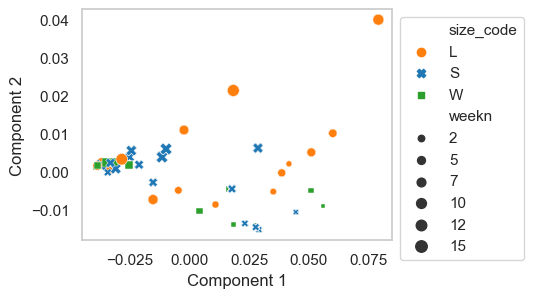

In [72]:
pcaplot(separated, 1, '18S')

In [97]:
def boxplot_depth(separated, comm, depth, ycolumn, yaxislabel='def'):
    
    if comm == '16S':
        comm_id = '02-PROKs'
    else:
        comm_id = '02-EUKs'
    
    if yaxislabel != 'def':
        ycol = ycolumn
    
    sfd=separated[separated.depth==depth]
    
    #define color palettes
    sizecodes = ['S', 'L', 'W']
    palette_colors = sns.color_palette()
    palette_dict = {sizecode: color for sizecode, color in zip(sizecodes, palette_colors)}
    
    #plot
    sns.set(rc={"figure.figsize":(4, 3)})
    sns.boxplot(data=sfd, x="size_code", y=ycolumn, palette=palette_dict, order=['S', 'L', 'W'])#, hue="size_code")
    plt.ylabel(yaxislabel)
    plt.xlabel('Size fraction')
    plt.savefig('outputs/'+comm_id+'/D'+str(depth)+'_adboxplot.png', dpi=200, bbox_inches="tight")
    plt.clf()
    plt.cla()
    plt.close()
    
    sns.set(rc={"figure.figsize":(7, 3)})
    ax=sns.barplot(data=sfd, x="weekn", y="diff", hue="size_code", palette=palette_dict)#, hue="size_code")
    plt.ylabel('Number of ASVs relative to weekly average')
    plt.xlabel('Week number')
    plt.savefig('outputs/'+comm_id+'/D'+str(depth)+'_avgbarplot.png', dpi=200, bbox_inches="tight")

    plt.clf() 
    sns.set(rc={"figure.figsize":(7, 3)})
    ax=sns.lineplot(x = "weekn", y = ycolumn, data=sfd, hue="size_code", palette=palette_dict)
    plt.ylabel(yaxislabel)
    plt.xlabel('Week')
    plt.legend(title='Size fraction')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.savefig('outputs/'+comm_id+'/D'+str(depth)+'_adlineplot.png', dpi=200, bbox_inches="tight")

In [105]:
def upsetprep(comm, level):
    if comm == '16S':
        comm_id = '02-PROKs'
    else:
        comm_id = '02-EUKs'
        
    depths = [1, 5, 10, 30, 60]
    
    cumulab = separated[['feature_frequency', 'depth', 'size_code', level]].copy()
    cumulab1 = cumulab.groupby([level]).agg({'feature_frequency':sum})
    
    for d in depths:
        #make csv
        sfd=separated[separated.depth==d]
        
        toptaxa = sfd[['feature_id', 'feature_frequency', 'Taxon', 'size_code', 'depth','weekn', level]].copy()
        toptaxa = toptaxa.drop_duplicates()
        df_agg = toptaxa.groupby(['size_code',level, 'depth']).agg({'feature_frequency':sum})
        topd = df_agg['feature_frequency'].groupby('size_code', group_keys=False).nlargest(10)
        topd = topd.to_frame()
        topd = topd.reset_index()

        df_agg = df_agg.reset_index()
        df_agg['set_name'] = df_agg['size_code']+df_agg['depth'].astype(str)
    
        resultpivot = df_agg.pivot_table(index=level, columns='set_name', values='feature_frequency')
        resultpivot = resultpivot.fillna(0)
        resultpivot[resultpivot != 0] = 1
        tosave = pd.merge(resultpivot, cumulab1, left_index=True, right_index=True)
        tosave.to_csv('csvs/'+comm_id+'/'+level+'_d'+str(d)+'_relab.csv')
        
        
        #make json
        data = {
            "file": "https://raw.githubusercontent.com/dianahaider/size_fractions/main/csvs/"+comm_id+'/'+level+'_d'+str(d)+'_relab.csv',
            "name": comm + level,
            "header": 0,
            "separator": ",",
            "skip": 0,
            "meta":[
                {"type":"id", "index":0, "name":"Name"},
                {"type":"integer", "index":4, "name":"Rel. ab."}
            ],
            "sets": [
                {"format": "binary", "start":1, "end": 3}
            ]
        }
        
        with open('json/'+comm_id+'/'+level+'_d'+str(d)+'.json', 'w') as f:
            json.dump(data, f)

Data prep

In [78]:
df, comm = consolidate_tables('18S')

Found all 18S tables.
Successfully saved all tables.


In [12]:
merged = merge_metadata(df)

Set up metadata ...
Saved merged_asvs_metadata.tsv


In [13]:
separated = pick_metadata(merged)

Appended all taxonomies to taxos
Saved separated by metadata dataframe.


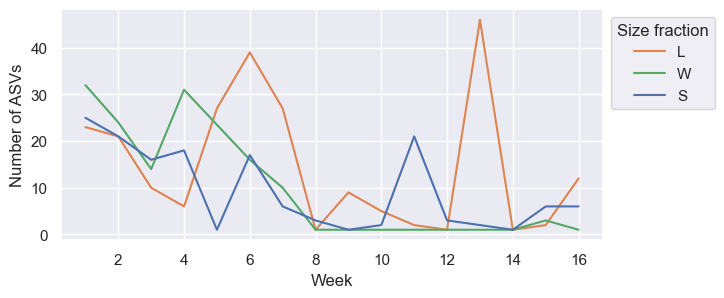

In [98]:
boxplot_depth(separated, comm, 1, 'nASVs', 'Number of ASVs')

In [22]:
taxbarplot(separated, 'Phylum', 60, 10)

### Upset plot data prep

In [106]:
upsetprep('18S', 'Class')

In [ ]:
#if we want to make an upset plot of all depths?

frames = sfd1, sfd5, sfd10, sfd30, sfd60
result = pd.concat(frames)
resultpivot = result.pivot_table(index='Genus', columns='set_name', values='feature_frequency')
resultpivot = resultpivot.fillna(0)
resultpivot[resultpivot != 0] = 1
tosave = pd.merge(resultpivot, cumulab1, left_index=True, right_index=True)
tosave.to_csv('genus_all16S_relab.csv')

### Venn diagrams

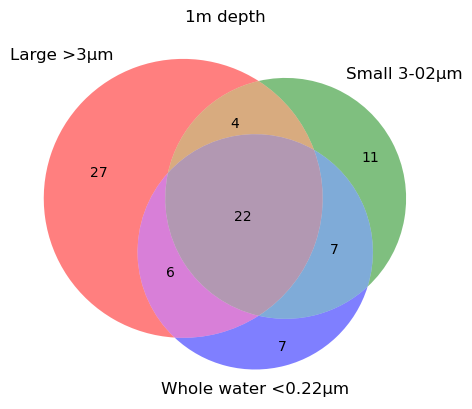

In [37]:
#Depth 1 all 16S at genus level
#N=84
venn3(subsets = (27, 11, 4, 7, 6, 7, 22), set_labels = ('Large >3μm', 'Small 3-02μm', 'Whole water <0.22μm'), alpha = 0.5);

plt.title("1m depth") 
plt.savefig("outputs/02-EUKs/D1_genus_venn.png")
plt.show()

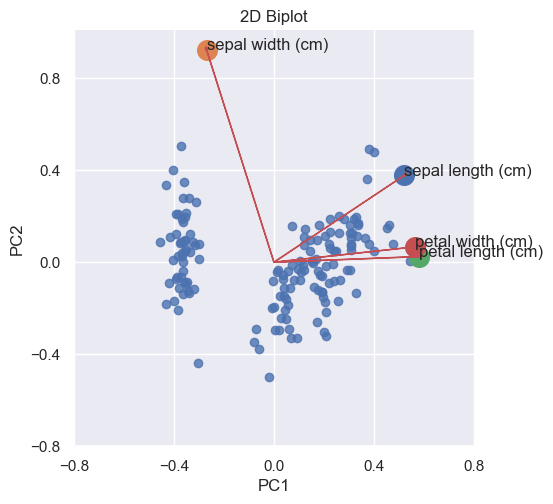

In [71]:
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
sns.set()
 
# load features and targets separately
iris = datasets.load_iris()
X = iris.data
y = iris.target
 
# Scale Data 
x_scaled = StandardScaler().fit_transform(X)
 
# Perform PCA on Scaled Data
pca = PCA(n_components=2)
 
 
pca_features = pca.fit_transform(x_scaled)
 
# Principal components correlation coefficients
loadings = pca.components_
 
# Number of features before PCA
n_features = pca.n_features_in_
 
# Feature names before PCA
feature_names = iris.feature_names
 
# PC names
pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]
 
# Match PC names to loadings
pc_loadings = dict(zip(pc_list, loadings))
 
# Matrix of corr coefs between feature names and PCs
loadings_df = pd.DataFrame.from_dict(pc_loadings)
loadings_df['feature_names'] = feature_names
loadings_df = loadings_df.set_index('feature_names')
 
 
# Get the loadings of x and y axes
xs = loadings[0]
ys = loadings[1]
 
 
# Create DataFrame from PCA
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2'])
 
# Map Targets to names
target_names = {
    0:'setosa',
    1:'versicolor', 
    2:'virginica'
}
 
pca_df['target'] = y
pca_df['target'] = pca_df['target'].map(target_names)
 
# Scale PCS into a DataFrame
pca_df_scaled = pca_df.copy()
 
scaler_df = pca_df[['PC1', 'PC2']]
scaler = 1 / (scaler_df.max() - scaler_df.min())
 
for index in scaler.index:
    pca_df_scaled[index] *= scaler[index]
 
 
# Plot the loadings on a Scatter plot
xs = loadings[0]
ys = loadings[1]
 
sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=pca_df_scaled, 
    fit_reg=False, 
    )
 
for i, varnames in enumerate(feature_names):
    plt.scatter(xs[i], ys[i], s=200)
    plt.arrow(
        0, 0, # coordinates of arrow base
        xs[i], # length of the arrow along x
        ys[i], # length of the arrow along y
        color='r', 
        head_width=0.01
        )
    plt.text(xs[i], ys[i], varnames)
 
xticks = np.linspace(-0.8, 0.8, num=5)
yticks = np.linspace(-0.8, 0.8, num=5)
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('PC1')
plt.ylabel('PC2')
 
plt.title('2D Biplot')
plt.show()